In [23]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [24]:
cat_directory = './data/mars/training/catalogs/'
cat_file = cat_directory + 'Mars_InSight_training_catalog_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005,2022-02-03T08:08:27.000000,507,evid0005
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006,2022-01-02T04:35:30.000000,2130,evid0006


In [25]:
row = cat.iloc[0]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(2022, 2, 3, 8, 8, 27)

In [26]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

507

In [27]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'XB.ELYSE.02.BHV.2022-02-03HR08_evid0005'

In [28]:
data_directory = './data/mars/training/data/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time(%Y-%m-%dT%H:%M:%S.%f),rel_time(sec),velocity(c/s)
0,2022-02-03T08:00:00.009000,0.00,0.000000
1,2022-02-03T08:00:00.059000,0.05,0.000128
2,2022-02-03T08:00:00.109000,0.10,0.000703
3,2022-02-03T08:00:00.159000,0.15,-0.001124
4,2022-02-03T08:00:00.209000,0.20,-0.003985
...,...,...,...
71995,2022-02-03T08:59:59.759000,3599.75,-0.003213
71996,2022-02-03T08:59:59.809000,3599.80,-0.003827
71997,2022-02-03T08:59:59.859000,3599.85,-0.002980
71998,2022-02-03T08:59:59.909000,3599.90,-0.000506


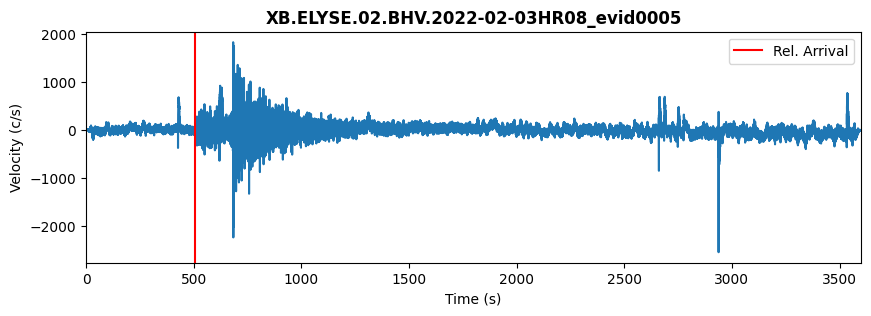

In [29]:
# Read in time steps and velocities
csv_times = np.array(data_cat['rel_time(sec)'].tolist())
csv_data = np.array(data_cat['velocity(c/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (c/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

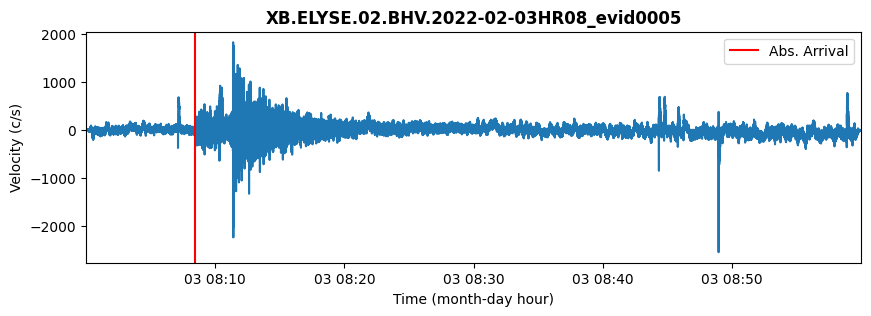

In [30]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(c/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (c/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

In [31]:
data_directory = './data/mars/training/data/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-02-03T08:00:00.009000Z - 2022-02-03T08:59:59.959000Z | 20.0 Hz, 72000 samples

In [32]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [33]:
st[0].stats

         network: XB
         station: ELYSE
        location: 02
         channel: BHV
       starttime: 2022-02-03T08:00:00.009000Z
         endtime: 2022-02-03T08:59:59.959000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 72000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 143, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 585728})

In [34]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

506.991

Text(0.5, 1.0, 'XB.ELYSE.02.BHV.2022-02-03HR08_evid0005')

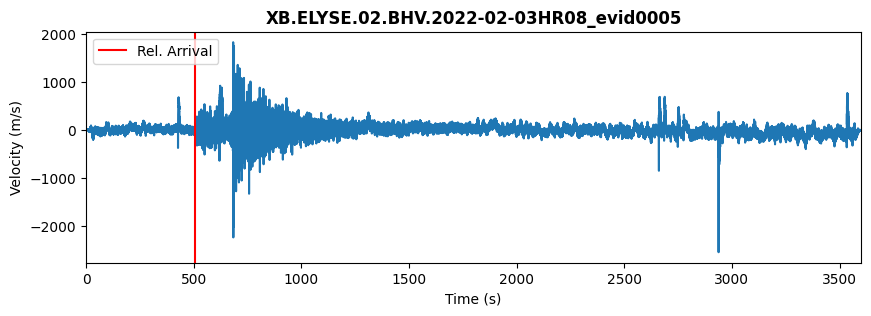

In [35]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

Text(0.5, 1.0, 'XB.ELYSE.02.BHV.2022-02-03HR08_evid0005')

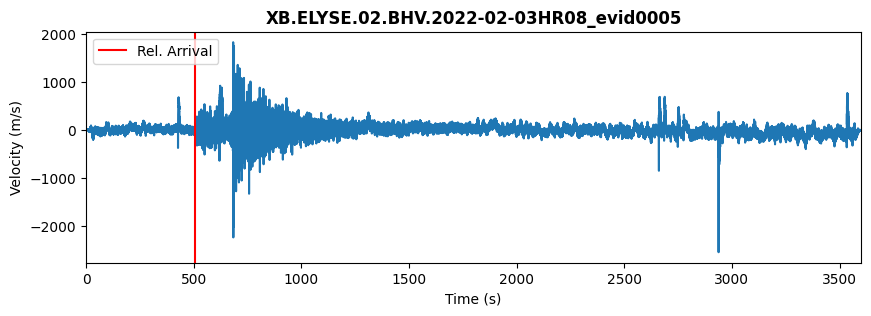

In [36]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

In [37]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [38]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

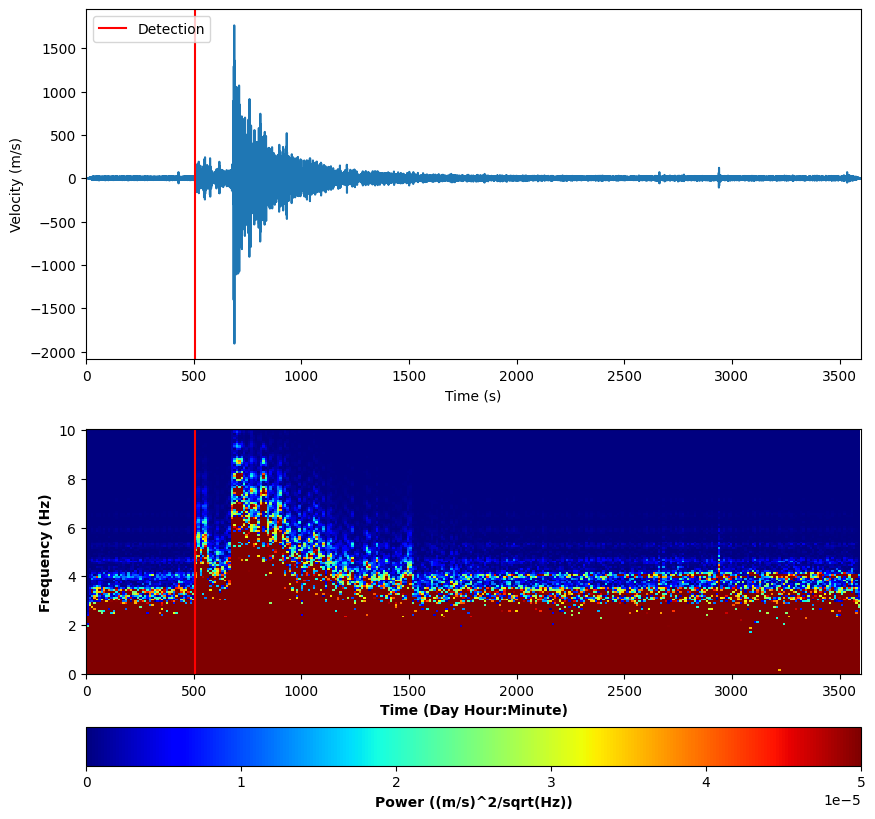

In [39]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-5)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

Text(0, 0.5, 'Characteristic function')

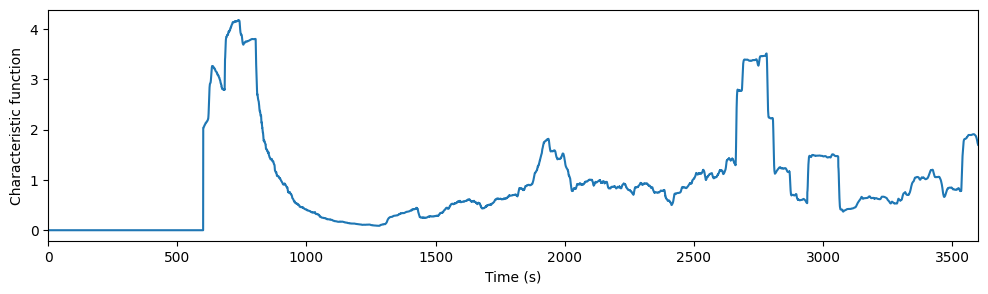

In [40]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

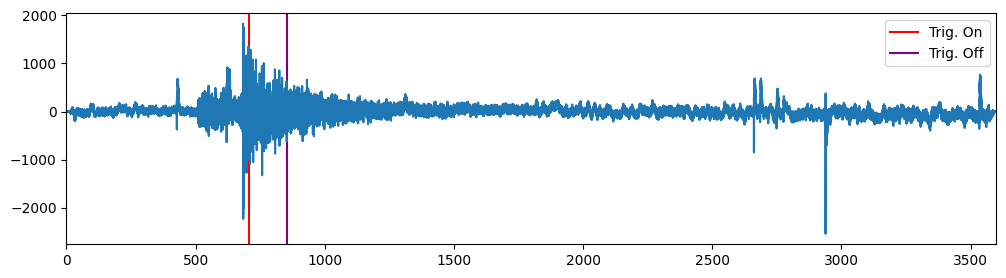

In [41]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

In [42]:
# File name and start time of trace
fname = row.filename
starttime = tr.stats.starttime.datetime

# Initialize lists to collect detection times and relative times
detection_times = []
fnames = []
rel_times = []  # List to store relative times

# Iterate through detection times and compile them
for triggers in on_off:
    on_time = starttime + timedelta(seconds=tr_times[triggers[0]])
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)
    rel_times.append(tr_times[triggers[0]])

# Compile dataframe of detections
detect_df = pd.DataFrame({
    'filename': fnames,
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': detection_times,
    'time_rel(sec)': rel_times
})
detect_df.head()

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005,2022-02-03T08:11:44.659000,704.65


In [43]:
detect_df.to_csv('./output/catalog.csv', index=False)

Confusion Matrix:
[[21149     0]
 [    7   384]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21149
           1       1.00      0.98      0.99       391

    accuracy                           1.00     21540
   macro avg       1.00      0.99      1.00     21540
weighted avg       1.00      1.00      1.00     21540


ROC AUC Score:
0.9910485933503836


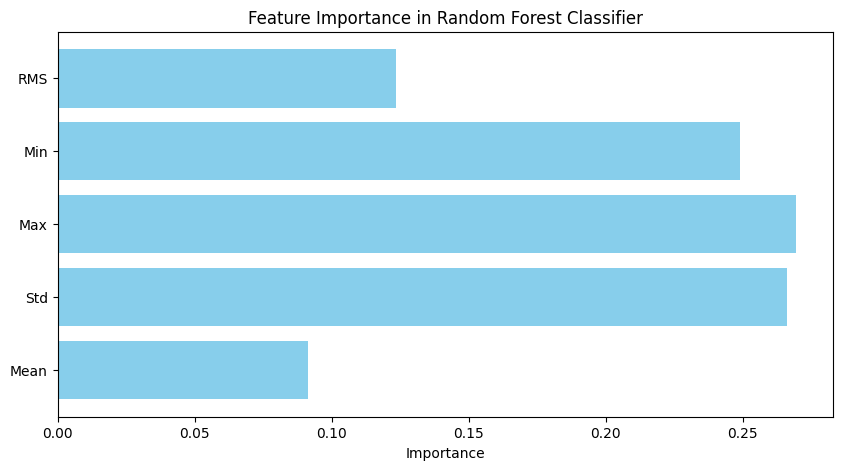

Predictions for new data: [0 0 0 ... 0 0 0]


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy import signal
import joblib

# Load the seismic data from CSV file
data_path = './data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv'
data = pd.read_csv(data_path)

# Feature Extraction
window_size = 200  # Size of the sliding window to extract features
X = []  # Feature matrix
y = []  # Labels (0 for noise, 1 for marsquake)

# Assuming that we already have trigger points in the form of a DataFrame
# where trigger_on_time and trigger_off_time are the columns with rel_time values
detect_df_path = './output/catalog.csv'
detect_df = pd.read_csv(detect_df_path)

# Convert trigger times to a list of tuples for easy checking
trigger_intervals = [(row['time_rel(sec)'], row['time_rel(sec)'] + 60) for _, row in detect_df.iterrows()]

# Sliding window approach to extract features and label the data
for i in range(len(data) - window_size):
    window_data = data['velocity(c/s)'][i:i + window_size].values
    
    # Extract features for each window
    feature_mean = np.mean(window_data)
    feature_std = np.std(window_data)
    feature_max = np.max(window_data)
    feature_min = np.min(window_data)
    feature_rms = np.sqrt(np.mean(window_data ** 2))
    
    # Append extracted features
    X.append([feature_mean, feature_std, feature_max, feature_min, feature_rms])
    
    # Determine label based on trigger intervals
    current_time = data['rel_time(sec)'][i]
    is_quake = any(start <= current_time <= end for start, end in trigger_intervals)
    y.append(1 if is_quake else 0)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Handle class imbalance by using class weights in RandomForestClassifier
class_weights = {0: 1.0, 1: len(y) / sum(y)}  # Weight the minority class more heavily

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
clf.fit(X_train, y_train)

# Save the trained model for future use
joblib.dump(clf, 'marsquake_rf_model.pkl')
joblib.dump(scaler, 'marsquake_scaler.pkl')

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

# Plotting the feature importance for better interpretability
importances = clf.feature_importances_
feature_names = ['Mean', 'Std', 'Max', 'Min', 'RMS']
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

# Function to make predictions on new data
def predict_marsquake(new_data_path):
    # Load the new data
    new_data = pd.read_csv(new_data_path)
    
    # Extract features using the same sliding window method
    new_X = []
    for i in range(len(new_data) - window_size):
        window_data = new_data['velocity(c/s)'][i:i + window_size].values
        feature_mean = np.mean(window_data)
        feature_std = np.std(window_data)
        feature_max = np.max(window_data)
        feature_min = np.min(window_data)
        feature_rms = np.sqrt(np.mean(window_data ** 2))
        new_X.append([feature_mean, feature_std, feature_max, feature_min, feature_rms])
    
    # Convert to numpy array and standardize using the saved scaler
    new_X = np.array(new_X)
    scaler = joblib.load('marsquake_scaler.pkl')
    new_X = scaler.transform(new_X)
    
    # Load the saved model
    model = joblib.load('marsquake_rf_model.pkl')
    
    # Make predictions
    predictions = model.predict(new_X)
    
    # Return predictions
    return predictions

# Example usage
new_data_path = './data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv'
try:
    predictions = predict_marsquake(new_data_path)
    print(f"Predictions for new data: {predictions}")
except FileNotFoundError:
    print(f"File '{new_data_path}' not found. Please provide the correct path.")

Epoch 1/20


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9618 - loss: 0.2160 - val_accuracy: 0.9818 - val_loss: 0.0467
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9837 - loss: 0.0442 - val_accuracy: 0.9818 - val_loss: 0.0438
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9834 - loss: 0.0419 - val_accuracy: 0.9818 - val_loss: 0.0419
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9843 - loss: 0.0387 - val_accuracy: 0.9818 - val_loss: 0.0405
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9842 - loss: 0.0386 - val_accuracy: 0.9818 - val_loss: 0.0392
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9831 - loss: 0.0375 - val_accuracy: 0.9818 - val_loss: 0.0384
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9857 - loss: 0.0319 - val_accuracy: 0.9825 - val_loss: 0.0373
Epoch 8/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9841 - loss: 0.0350 - val_accurac

674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9857 - loss: 0.0278
Test Accuracy: 0.9848653674125671


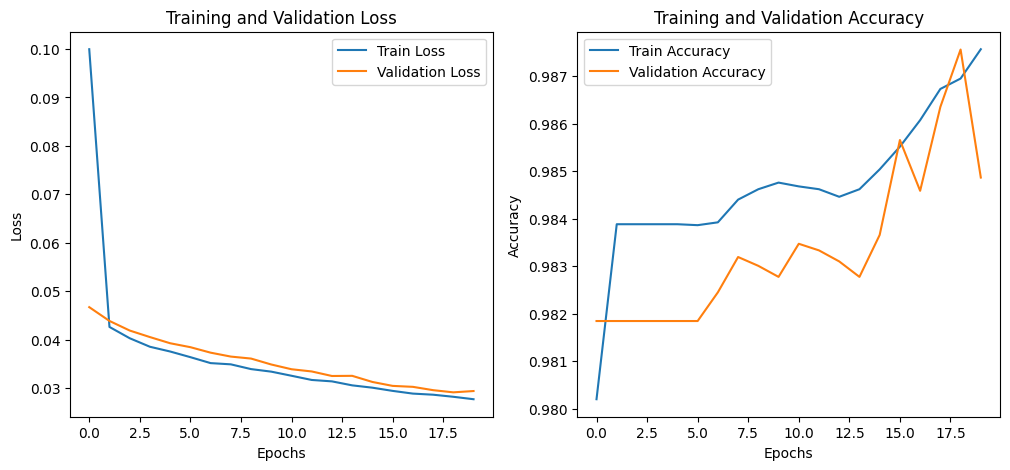

2244/2244 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Predictions for new data: [0 0 0 ... 0 0 0]


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load the seismic data from CSV file
data_path = './data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv'
data = pd.read_csv(data_path)

# Feature Extraction
window_size = 200  # Size of the sliding window to extract features
X = []  # Feature matrix
y = []  # Labels (0 for noise, 1 for marsquake)

# Assuming that we already have trigger points in the form of a DataFrame
# where trigger_on_time and trigger_off_time are the columns with rel_time values
detect_df_path = './output/catalog.csv'
detect_df = pd.read_csv(detect_df_path)

# Convert trigger times to a list of tuples for easy checking
trigger_intervals = [(row['time_rel(sec)'], row['time_rel(sec)'] + 60) for _, row in detect_df.iterrows()]

# Sliding window approach to extract features and label the data
for i in range(len(data) - window_size):
    window_data = data['velocity(c/s)'][i:i + window_size].values
    
    # Extract features for each window
    feature_mean = np.mean(window_data)
    feature_std = np.std(window_data)
    feature_max = np.max(window_data)
    feature_min = np.min(window_data)
    feature_rms = np.sqrt(np.mean(window_data ** 2))
    
    # Append extracted features
    X.append([feature_mean, feature_std, feature_max, feature_min, feature_rms])
    
    # Determine label based on trigger intervals
    current_time = data['rel_time(sec)'][i]
    is_quake = any(start <= current_time <= end for start, end in trigger_intervals)
    y.append(1 if is_quake else 0)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model and scaler for future use
model.save('marsquake_lstm_model.h5')
joblib.dump(scaler, 'marsquake_scaler.pkl')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Function to make predictions on new data using the LSTM model
def predict_marsquake(new_data_path):
    # Load the new data
    new_data = pd.read_csv(new_data_path)
    
    # Extract features using the same sliding window method
    new_X = []
    for i in range(len(new_data) - window_size):
        window_data = new_data['velocity(c/s)'][i:i + window_size].values
        feature_mean = np.mean(window_data)
        feature_std = np.std(window_data)
        feature_max = np.max(window_data)
        feature_min = np.min(window_data)
        feature_rms = np.sqrt(np.mean(window_data ** 2))
        new_X.append([feature_mean, feature_std, feature_max, feature_min, feature_rms])
    
    # Convert to numpy array and standardize using the saved scaler
    new_X = np.array(new_X)
    new_X = scaler.transform(new_X)
    
    # Reshape data for LSTM
    new_X = new_X.reshape((new_X.shape[0], 1, new_X.shape[1]))
    
    # Load the saved LSTM model
    model = tf.keras.models.load_model('marsquake_lstm_model.h5')
    
    # Make predictions
    predictions = model.predict(new_X)
    predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels
    
    # Return predictions
    return predictions

# Example usage
new_data_path = './data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv'
try:
    predictions = predict_marsquake(new_data_path)
    print(f"Predictions for new data: {predictions.flatten()}")
except FileNotFoundError:
    print(f"File '{new_data_path}' not found. Please provide the correct path.")

Confusion Matrix:
[[21149     0]
 [    7   384]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21149
           1       1.00      0.98      0.99       391

    accuracy                           1.00     21540
   macro avg       1.00      0.99      1.00     21540
weighted avg       1.00      1.00      1.00     21540


ROC AUC Score:
0.9910485933503836


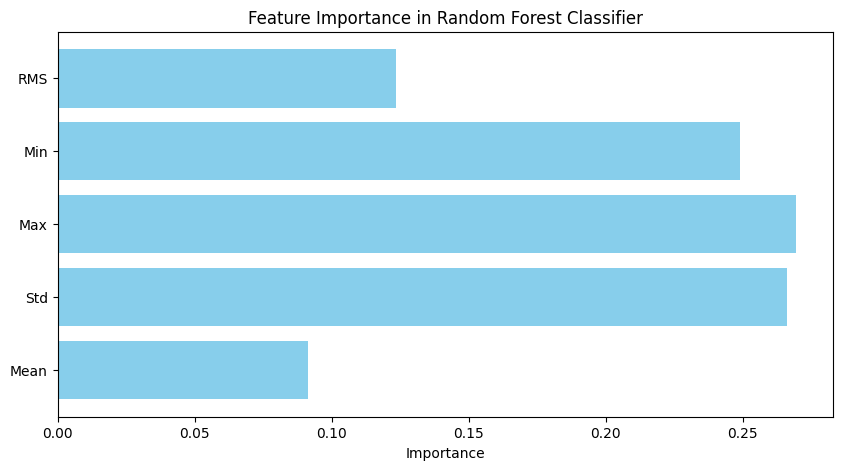

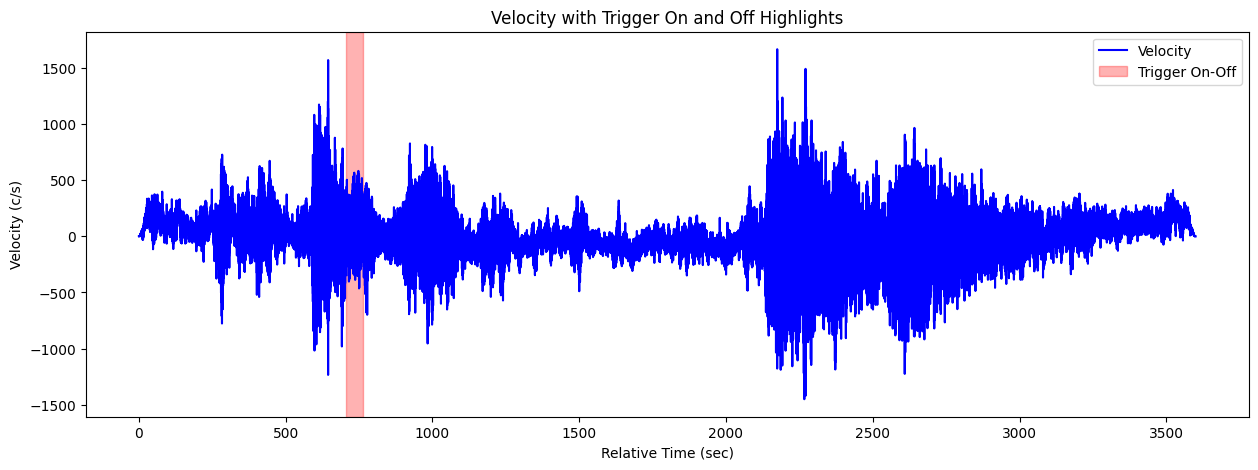

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy import signal
import joblib
import os

# Load the seismic data from CSV file
data_path = './data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv'
data = pd.read_csv(data_path)

# Feature Extraction
window_size = 200  # Size of the sliding window to extract features
X = []  # Feature matrix
y = []  # Labels (0 for noise, 1 for marsquake)

# Assuming that we already have trigger points in the form of a DataFrame
# where trigger_on_time and trigger_off_time are the columns with rel_time values
detect_df_path = './output/catalog.csv'
detect_df = pd.read_csv(detect_df_path)

# Convert trigger times to a list of tuples for easy checking
trigger_intervals = [(row['time_rel(sec)'], row['time_rel(sec)'] + 60) for _, row in detect_df.iterrows()]

# Sliding window approach to extract features and label the data
for i in range(len(data) - window_size):
    window_data = data['velocity(c/s)'][i:i + window_size].values
    
    # Extract features for each window
    feature_mean = np.mean(window_data)
    feature_std = np.std(window_data)
    feature_max = np.max(window_data)
    feature_min = np.min(window_data)
    feature_rms = np.sqrt(np.mean(window_data ** 2))
    
    # Append extracted features
    X.append([feature_mean, feature_std, feature_max, feature_min, feature_rms])
    
    # Determine label based on trigger intervals
    current_time = data['rel_time(sec)'][i]
    is_quake = any(start <= current_time <= end for start, end in trigger_intervals)
    y.append(1 if is_quake else 0)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Handle class imbalance by using class weights in RandomForestClassifier
class_weights = {0: 1.0, 1: len(y) / sum(y)}  # Weight the minority class more heavily

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
clf.fit(X_train, y_train)

# Save the trained model for future use
joblib.dump(clf, 'marsquake_rf_model.pkl')
joblib.dump(scaler, 'marsquake_scaler.pkl')

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

# Plotting the feature importance for better interpretability
importances = clf.feature_importances_
feature_names = ['Mean', 'Std', 'Max', 'Min', 'RMS']
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

# Function to make predictions on new data
def predict_marsquake(new_data_path):
    # Load the new data
    new_data = pd.read_csv(new_data_path)
    
    # Extract features using the same sliding window method
    new_X = []
    for i in range(len(new_data) - window_size):
        window_data = new_data['velocity(c/s)'][i:i + window_size].values
        feature_mean = np.mean(window_data)
        feature_std = np.std(window_data)
        feature_max = np.max(window_data)
        feature_min = np.min(window_data)
        feature_rms = np.sqrt(np.mean(window_data ** 2))
        new_X.append([feature_mean, feature_std, feature_max, feature_min, feature_rms])
    
    # Convert to numpy array and standardize using the saved scaler
    new_X = np.array(new_X)
    scaler = joblib.load('marsquake_scaler.pkl')
    new_X = scaler.transform(new_X)
    
    # Load the saved model
    model = joblib.load('marsquake_rf_model.pkl')
    
    # Make predictions
    predictions = model.predict(new_X)
    
    # Return predictions
    return predictions

# Function to automatically test multiple test sets
def test_multiple_sets(test_dir):
    test_files = [f for f in os.listdir(test_dir) if f.endswith('.csv')]
    results = {}
    for test_file in test_files:
        test_file_path = os.path.join(test_dir, test_file)
        try:
            predictions = predict_marsquake(test_file_path)
            results[test_file] = predictions
            print(f"Predictions for {test_file}: {predictions}")
        except FileNotFoundError:
            print(f"File '{test_file_path}' not found. Please provide the correct path.")
    return results

# Function to plot velocity with multiple trigger on and off highlights
def plot_velocity_with_triggers(data_path, detect_df_path):
    # Load the seismic data
    data = pd.read_csv(data_path)
    detect_df = pd.read_csv(detect_df_path)
    
    # Convert trigger times to a list of tuples for easy checking
    trigger_intervals = [(row['time_rel(sec)'], row['time_rel(sec)'] + 60) for _, row in detect_df.iterrows()]
    
    # Plot velocity data
    plt.figure(figsize=(15, 5))
    plt.plot(data['rel_time(sec)'], data['velocity(c/s)'], label='Velocity (c/s)', color='blue')
    
    # Highlight multiple trigger on and off intervals
    for start, end in trigger_intervals:
        plt.axvspan(start, end, color='red', alpha=0.3)
    
    plt.xlabel('Relative Time (sec)')
    plt.ylabel('Velocity (c/s)')
    plt.title('Velocity with Trigger On and Off Highlights')
    plt.legend(['Velocity', 'Trigger On-Off'])
    plt.show()

# Example usage of plotting function
plot_velocity_with_triggers(data_path, detect_df_path)

# Example usage of automatic testing
test_dir = './data/mars/test/'
try:
    test_results = test_multiple_sets(test_dir)
except FileNotFoundError:
    print(f"Directory '{test_dir}' not found. Please provide the correct path.")